### LSTM: Stock Price and Sentiment Analysis

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

In [2]:
#Read the csv file 
#In this file were merged the 'avg_compound' which is the Result od the Sentiment Analysis + all features from the Stock Price Data.
df = pd.read_csv('merged_df2.csv')
print(df.head()) #8 columns, including the Date. 

         Date  avg_compound       Open       High        Low      Close  \
0  2022-03-07     -0.224473  28.370001  28.730000  27.969999  28.500000   
1  2022-03-16     -0.187827  28.389999  28.620001  28.139999  28.610001   
2  2022-03-17      0.041381  28.969999  29.230000  28.809999  29.040001   
3  2022-03-18     -0.055770  28.660000  28.850000  28.370001  28.740000   
4  2022-04-04     -0.043263  30.000000  30.040001  29.620001  29.790001   

   Adj Close      Volume  
0  26.031946  26330200.0  
1  26.132420  17662100.0  
2  26.525185  18703900.0  
3  26.251162  16269400.0  
4  27.210234  13298000.0  


In [3]:
#Converting dates to 'datetime'
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(5)) #Check last few dates. 

521   2024-03-22
522   2024-03-25
523   2024-03-26
524   2024-03-27
525   2024-03-28
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:7]
#Date column is not used in training. 
print(cols) 

['avg_compound', 'Open', 'High', 'Low', 'Close', 'Adj Close']


In [5]:
#New dataframe with only training data - 6 columns
df_for_training = df[cols]
print(df_for_training.head())

   avg_compound       Open       High        Low      Close  Adj Close
0     -0.224473  28.370001  28.730000  27.969999  28.500000  26.031946
1     -0.187827  28.389999  28.620001  28.139999  28.610001  26.132420
2      0.041381  28.969999  29.230000  28.809999  29.040001  26.525185
3     -0.055770  28.660000  28.850000  28.370001  28.740000  26.251162
4     -0.043263  30.000000  30.040001  29.620001  29.790001  27.210234


<Axes: >

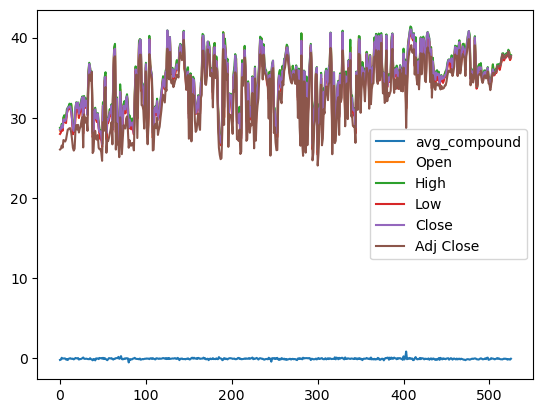

In [6]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [7]:
# normalize the dataset
scaler = RobustScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

<Axes: >

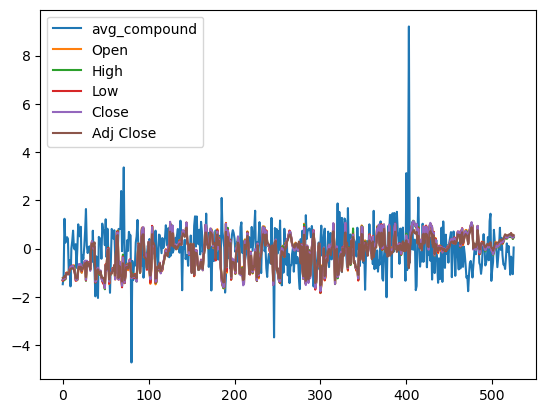

In [8]:
# Convert the scaled array back to a DataFrame
df_for_training_scaled_plot = pd.DataFrame(df_for_training_scaled, columns=df_for_training.columns)
# Select the last 5000 rows
df_for_plot2 = df_for_training_scaled_plot.tail(5000)
# Plot the DataFrame
df_for_plot2.plot.line()

In [9]:
# # Convert the scaled array back to DataFrame with appropriate column names
# df_for_training_scaled = pd.DataFrame(df_for_training_scaled, columns=df_for_training.columns)

# # Plot the scaled data
# df_for_plot_scaled = df_for_training_scaled.tail(5000)  # Plot the scaled data for the same range as original
# df_for_plot_scaled.plot.line()
# plt.show()

In [10]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (512, 14, 6).
trainY shape == (512, 1).


#### 548 rows / 14 days (n_past) / 5 variables 

In [11]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\leona\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.7423 - val_loss: 0.3846
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6705 - val_loss: 0.3551
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9080 - val_loss: 0.3334
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7238 - val_loss: 0.3356
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8532 - val_loss: 0.3314


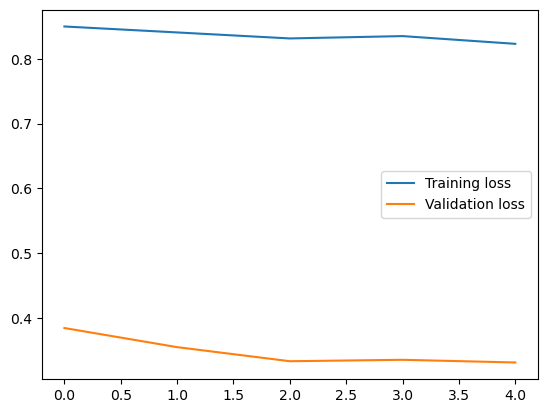

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [14]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

[Timestamp('2024-03-07 00:00:00'), Timestamp('2024-03-08 00:00:00'), Timestamp('2024-03-11 00:00:00'), Timestamp('2024-03-12 00:00:00'), Timestamp('2024-03-13 00:00:00'), Timestamp('2024-03-14 00:00:00'), Timestamp('2024-03-15 00:00:00'), Timestamp('2024-03-18 00:00:00'), Timestamp('2024-03-19 00:00:00'), Timestamp('2024-03-20 00:00:00'), Timestamp('2024-03-21 00:00:00'), Timestamp('2024-03-22 00:00:00'), Timestamp('2024-03-25 00:00:00'), Timestamp('2024-03-26 00:00:00'), Timestamp('2024-03-27 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


In [15]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [16]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [17]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-1-1']

C:\Users\leona\AppData\Local\Temp\ipykernel_7604\1258690779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [18]:
# sns.lineplot(original['Date'], original['Open'])
# sns.lineplot(df_forecast['Date'], df_forecast['Open'])

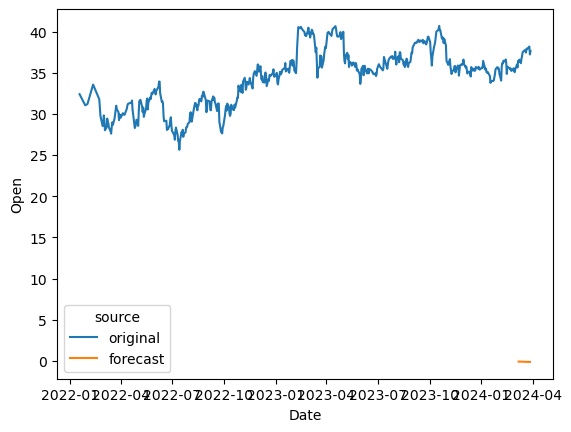

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime format in both 'original' and 'df_forecast'
original['Date'] = pd.to_datetime(original['Date'])
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Combine original and forecasted data into a single DataFrame with a new 'source' column
original['source'] = 'original'
df_forecast['source'] = 'forecast'
combined_data = pd.concat([original, df_forecast])

# Plotting the combined data
sns.lineplot(data=combined_data, x='Date', y='Open', hue='source')
plt.show()

In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

# Print final training and validation loss
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7089 - val_loss: 0.3271
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8870 - val_loss: 0.4026
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7977 - val_loss: 0.3457
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8311 - val_loss: 0.3947
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0937 - val_loss: 0.3761
Final training loss: 0.8187626600265503
Final validation loss: 0.3760862350463867


In [21]:
import math
from sklearn.metrics import mean_squared_error

# Predicting...
prediction = model.predict(trainX[-n_days_for_prediction:])

# Perform inverse transformation to rescale back to original range
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

# Obtain true values for the predicted period
true_values = df_for_training.values[-n_days_for_prediction:]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(true_values[:, 0], y_pred_future))
print("Root Mean Squared Error (RMSE):", rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Root Mean Squared Error (RMSE): 0.046284292583927


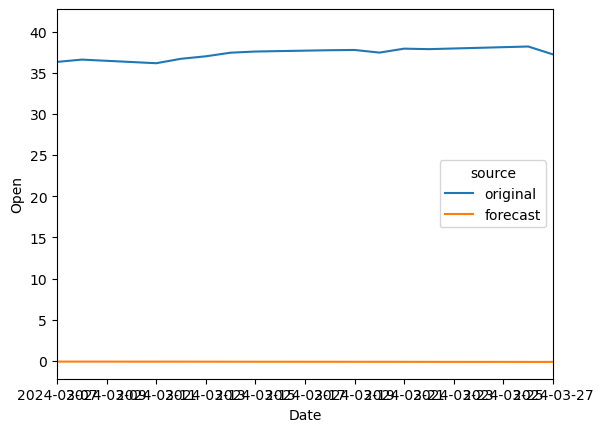

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime format in both 'original' and 'df_forecast'
original['Date'] = pd.to_datetime(original['Date'])
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Combine original and forecasted data into a single DataFrame with a new 'source' column
original['source'] = 'original'
df_forecast['source'] = 'forecast'
combined_data = pd.concat([original, df_forecast])

# Plotting the combined data
sns.lineplot(data=combined_data, x='Date', y='Open', hue='source')
plt.xlim(df_forecast['Date'].min(), df_forecast['Date'].max())  # Limit x-axis to forecast dates
plt.show()